1. 频率域语音信号-音频折线图
2. 用普减法对音频数据增强

In [32]:
import sys 
sys.path.append("..") 
from Func import ASRfunc

# 读取数据

wave_data, time_table = ASRfunc.read_wave("./data/enhance_speach_input_file.wav")

print(
    "音频数据: {}\n".format(wave_data)+
    "音频长度: {}\n".format(wave_data.shape)+
    "时间长度: {}".format(time_table.shape)
)

音频数据: [[ 22  19 -11 ...  55  49  36]]
音频长度: (1, 190224)
时间长度: (190224,)


In [2]:
import numpy as np

def normalize_audio_data(data):
    """
    对音频数据进行归一化

    Parameters:
    - data: 二维音频数组(channels, samples).

    Returns:
    - normalized_data: 归一化后的音频数据.
    """
    
    data_array = np.array(data)
    # 对每个通道找最大绝对值
    max_abs_values = np.max(np.abs(data_array), axis=1, keepdims=True)
    # 避免除0的情况
    max_abs_values[max_abs_values == 0] = 1
    # 归一化
    normalized_data = data_array / max_abs_values
    return normalized_data

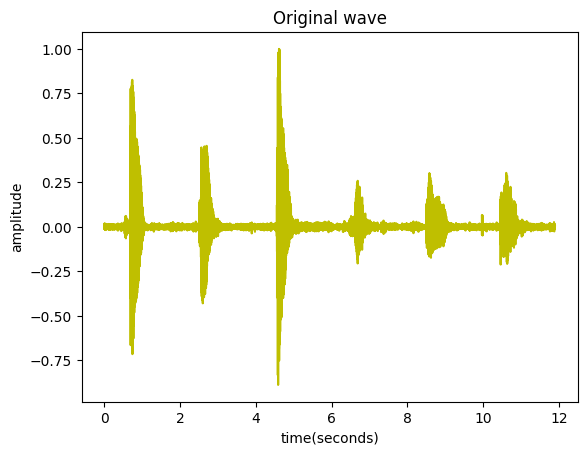

In [33]:
# 音频折线图
import matplotlib.pyplot as plt
# 归一化输入语音
normalized_data = normalize_audio_data(wave_data)
plt.figure()
plt.plot(time_table, normalized_data[0], c="y")
plt.xlabel("time(seconds)")
plt.ylabel("amplitude")
plt.title("Original wave")
plt.show()

默认混合信号(含噪信号)的前几帧仅包含环境噪声，并利用混合信号的前几帧的平均幅度谱或者能量谱作为估计到一帧噪声的幅度谱或者能量谱。  
最后利用混合信号(含噪信号)的幅度谱或者能量谱与估计到的幅度谱与能量谱相减，得到估计到的干净信号的幅度谱或者能量谱。

In [ ]:
import struct

def nextpow2(x):
    if x < 0:
        x = -x
    if x == 0:
        return 0
    
    # 将浮点数打包成字节
    packed_float = struct.pack('f', x)
    
    # 从字节中解包成整数
    bits = struct.unpack('I', packed_float)[0]
    
    # 提取符号位、指数和尾数
    S = (bits >> 31) & 0x01
    E = (bits >> 23) & 0xFF
    M = bits & 0x7FFFFF
    
    if M == 0:
        return E - 127
    return E - 127 + 1

In [9]:
# 谱减法

import numpy as np
import ctypes as ct
import math

framerate = 1.0 / np.mean(np.diff(time_table))

# 自定义函数
# 声明了两个C语言类FloatBits 和 Float
class FloatBits(ct.Structure):
    _fields_ = [
        ('M', ct.c_uint, 23),
        ('E', ct.c_uint, 8),
        ('S', ct.c_uint, 1)
    ]

class Float(ct.Union):
    _anonymous_ = ('bits',)
    _fields_ = [
        ('value', ct.c_float),
        ('bits', FloatBits)
    ]

def nextpow2(x):
    if x < 0:
        x = -x
    if x == 0:
        return 0
    d = Float()
    d.value = x
    if d.M == 0:
        return d.E - 127
    return d.E - 127 + 1   

# 计算参数
len_ = int(20  framerate // 1000) # 样本中的帧长度
# 20ms对应的采样数对应的帧长度作为一个计算的基本单位
PERC = 50 # 窗口重叠占帧的百分比
len1 = len_  PERC // 100  # 重叠窗口
len2 = len_ - len1   # 非重叠窗口

# 设置默认参数
Thres = 3 # 信噪比阈值
Expnt = 2.0
beta = 0.002
G = 0.9

# 初始化汉明窗
win = np.hamming(len_)
print(len(win))

320
320


Hamming 窗口函数数学定义如下：

$$ w(n) = 0.54 - 0.46 \cos\left(\frac{2\pi n}{N-1}\right) $$


其中：
- w(n) 是窗口在位置 n 处的值。
- N 是窗口的长度。


In [14]:
# normalization gain for overlap+add with 50% overlap
# 归一化因子
winGain = len2 / sum(win)
print(winGain)

# 噪声幅度计算，假设前5帧为silence帧
"""
nFFT 为包含'当前帧长度'的一个'最小特定帧长度'(该特定帧长度可以方便傅里叶变换) 
nextpow2: 用于计算最小特定帧长度

关于傅里叶变换的补充:
傅里叶变换的性质要求输入信号的长度是2的幂次。
因此, nextpow2(len_) 计算出比 len_ 大的下一个2的幂。
将其乘以2可以确保有足够的频谱采样点, 使得频谱上的分辨率更高。
"""
print(len_)
print(nextpow2(len_))
nFFT = 2  2  (nextpow2(len_)) # 多乘一个 2 是为了超采样
print(nFFT)
noise_mean = np.zeros(nFFT)

0.9283973540675416
320
9
1024


In [20]:
# 计算噪声的频谱均值
"""
假定前5帧为噪声, 计算前5帧的频谱均值
"""
j = 0
for k in range(1, 6):
    noise_mean = noise_mean + abs(np.fft.fft(win  wave_data[0][j:j + len_], nFFT))
    j = j + len_
noise_mu = noise_mean / 5

print(len(noise_mu))

1024


In [26]:
insign = win  wave_data[0][0:len_]
print(insign.shape)
spec = np.fft.fft(insign, nFFT)
print(spec.shape)
# 计算幅值
sig = abs(spec)
print(sig.shape)
theta = np.angle(spec)

(320,)
(1024,)
(1024,)


In [27]:
# 分配内存并初始化变量a
k = 1
img = 1j
x_old = np.zeros(len1)
Nframes = len(wave_data[0]) // len2 - 1
xfinal = np.zeros(Nframes  len2)

# 谱减法 
# 根据公式求出每一帧的去噪后的幅值sub_speech
for n in range(0, Nframes):
    # 一个窗口内(一个单位帧长度内:len_)的数据
    # win 是汉明窗口权值
    insign = win  wave_data[0][k-1:k + len_ - 1]
    # FFT变换
    spec = np.fft.fft(insign, nFFT)
    # 计算幅值
    sig = abs(spec)

    # 计算相值
    theta = np.angle(spec)
    # 带噪信号峰值信噪比
    SNRseg = 10  np.log10(np.linalg.norm(sig, 2)  2 / np.linalg.norm(noise_mu, 2)  2)


    def berouti(SNR):
        if -5.0 <= SNR <= 20.0:
            a = 4 - SNR  3 / 20
        else:
            if SNR < -5.0:
                a = 5
            if SNR > 20:
                a = 1
        return a


    def berouti1(SNR):
        if -5.0 <= SNR <= 20.0:
            a = 3 - SNR  2 / 20
        else:
            if SNR < -5.0:
                a = 4
            if SNR > 20:
                a = 1
        return a

    if Expnt == 1.0:  # 幅度谱
        alpha = berouti1(SNRseg)
    else:  # 功率谱
        alpha = berouti(SNRseg)
    # 纯净信号 = 带噪信号 - 噪声信号
    sub_speech = sig  Expnt - alpha  noise_mu  Expnt;
    # 当纯净信号小于噪声信号的功率时，求差值
    diffw = sub_speech - beta  noise_mu  Expnt

    def find_index(x_list):
        index_list = []
        for i in range(len(x_list)):
            if x_list[i] < 0:
                index_list.append(i)
        return index_list

    z = find_index(diffw)
    if len(z) > 0:
        # 用估计出来的噪声信号表示下限值
        sub_speech[z] = beta  noise_mu[z]  Expnt
        
    # 更新噪声的估计
    if SNRseg < Thres: 
        noise_temp = G  noise_mu  Expnt + (1 - G)  sig  Expnt  # 平滑处理噪声功率谱
        noise_mu = noise_temp  (1 / Expnt)  # 新的噪声幅度谱
    # flipud函数实现矩阵的上下翻转，是以矩阵的“水平中线”为对称轴
    # 交换上下对称元素
    sub_speech[nFFT // 2 + 1:nFFT] = np.flipud(sub_speech[1:nFFT // 2])
    x_phase = (sub_speech  (1 / Expnt))  (np.array([math.cos(x) for x in theta]) + img  (np.array([math.sin(x) for x in theta])))
    # take the IFFT

    xi = np.fft.ifft(x_phase).real
    # --- Overlap and add ---------------
    xfinal[k-1:k + len2 - 1] = x_old + xi[0:len1]
    x_old = xi[0 + len1:len_]
    k = k + len2

In [29]:
print(xfinal.shape)

wave_data = (winGain  xfinal).astype(np.short)

(189920,)


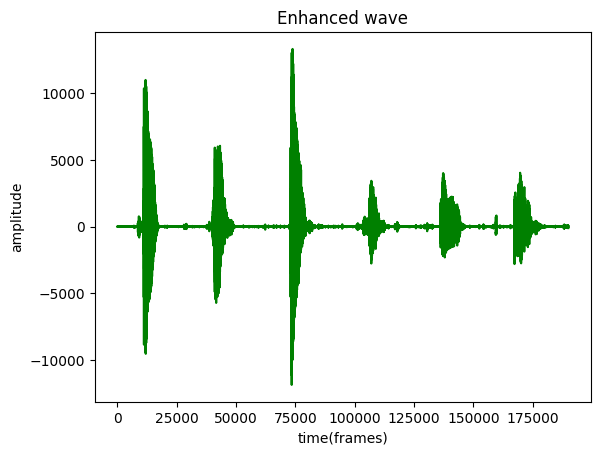

In [31]:
import numpy as np
import wave
import math
import ctypes as ct

# 绘制输入音频的时域波形
plt.figure()
plt.plot(wave_data,c="g")
plt.xlabel("time(frames)")
plt.ylabel("amplitude")
plt.title("Enhanced wave")
plt.show()